[Table of Contents](./table_of_contents.ipynb)

# Smoothing

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

## Introduction

The performance of the Kalman filter is not optimal when you consider future data. For example, suppose we are tracking an aircraft, and the latest measurement deviates far from the current track, like so (I'll only consider 1 dimension for simplicity):

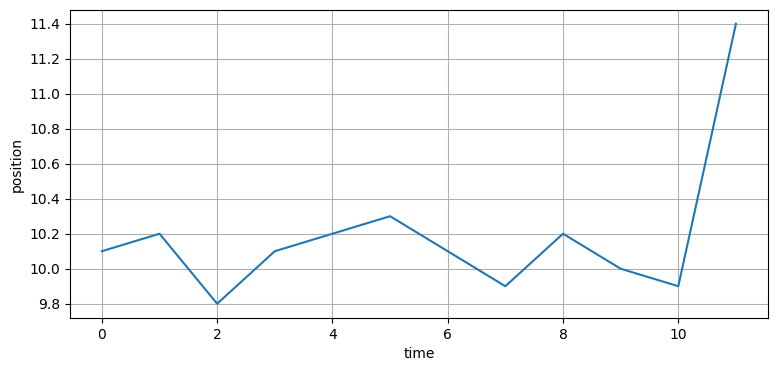

In [3]:
import matplotlib.pyplot as plt

data = [10.1, 10.2, 9.8, 10.1, 10.2, 10.3, 
        10.1, 9.9, 10.2, 10.0, 9.9, 11.4]
plt.plot(data)
plt.xlabel('time')
plt.ylabel('position');

After a period of near steady state, we have a very large change. Assume the change is past the limit of the aircraft's flight envelope. Nonetheless the Kalman filter incorporates that new measurement into the filter based on the current Kalman gain. It cannot reject the noise because the measurement could reflect the initiation of a turn. Granted it is unlikely that we are turning so abruptly, but it is impossible to say whether 
    
* The aircraft started a turn awhile ago, but the previous measurements were noisy and didn't show the change
      
* The aircraft is turning, and this measurement is very noisy
    
* The measurement is very noisy and the aircraft has not turned

* The aircraft is turning in the opposite direction, and the measurement is extremely noisy


Now, suppose the following measurements are:

   11.3 12.1 13.3 13.9 14.5 15.2
   

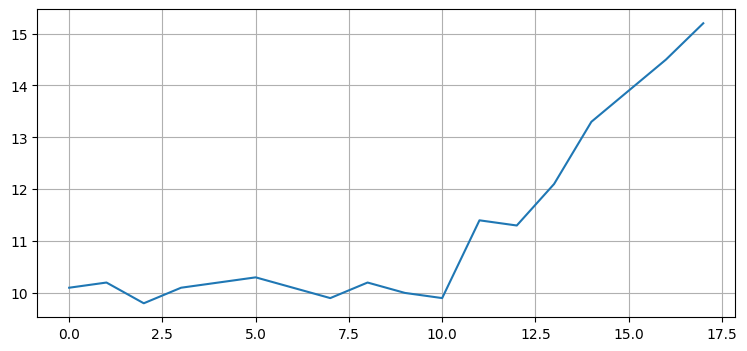

In [4]:
data2 = [11.3, 12.1, 13.3, 13.9, 14.5, 15.2]
plt.plot(data + data2);

Given these future measurements we can infer that yes, the aircraft initiated a turn. 

On the other hand, suppose these are the following measurements.

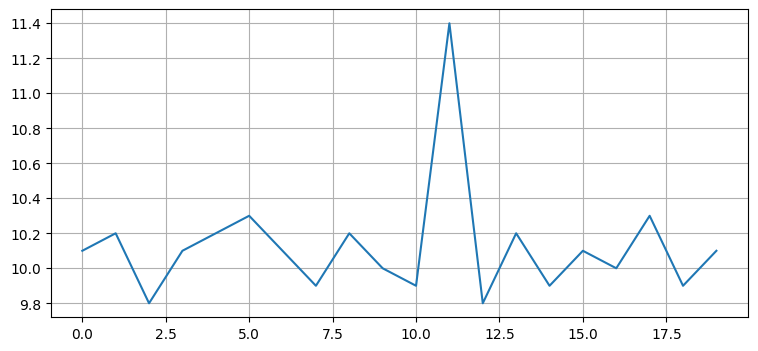

In [5]:
data3 = [9.8, 10.2, 9.9, 10.1, 10.0, 10.3, 9.9, 10.1]
plt.plot(data + data3);

In this case we are led to conclude that the aircraft did not turn and that the outlying measurement was merely very noisy. 

## An Overview of How Smoothers Work

The Kalman filter is a *recursive* filter with the Markov property - it's estimate at step `k` is  based only on the estimate from step `k-1` and the measurement at step `k`. But this means that the estimate from step `k-1` is based on step `k-2`, and so on back to the first epoch. Hence, the estimate at step `k` depends on all of the previous measurements, though to varying degrees. `k-1` has the most influence, `k-2` has the next most, and so on. 

Smoothing filters incorporate future measurements into the estimate for step `k`. The measurement from `k+1` will have the most effect, `k+2` will have less effect, `k+3` less yet, and so on. 

This topic is called *smoothing*, but I think that is a misleading name. I could smooth the data above by passing it through a low pass filter. The result would be smooth, but not necessarily accurate because a low pass filter will remove real variations just as much as it removes noise. In contrast, Kalman smoothers are *optimal* - they incorporate all available information to make the best estimate that is mathematically achievable.

## Types of Smoothers

There are three classes of Kalman smoothers that produce better tracking in these situations.

* Fixed-Interval Smoothing

This is a batch processing based filter. This filter waits for all of the data to be collected before making any estimates. For example, you may be a scientist collecting data for an experiment, and don't need to know the result until the experiment is complete. A fixed-interval smoother will collect all the data, then estimate the state at each measurement using all available previous and future measurements. If it is possible for you to run your Kalman filter in batch mode it is always recommended to use one of these filters as it will provide much better results than the recursive forms of the filter from the previous chapters.


* Fixed-Lag Smoothing

Fixed-lag smoothers introduce latency into the output. Suppose we choose a lag of 4 steps. The filter will ingest the first 3 measurements but not output a filtered result. Then, when the 4th measurement comes in the filter will produce the output for measurement 1, taking measurements 1 through 4 into account. When the 5th measurement comes in, the filter will produce the result for measurement 2, taking measurements 2 through 5 into account. This is useful when you need recent data but can afford a bit of lag. For example, perhaps you are using machine vision to monitor a manufacturing process. If you can afford a few seconds delay in the estimate a fixed-lag smoother will allow you to produce very accurate and smooth results.


* Fixed-Point Smoothing

A fixed-point filter operates as a normal Kalman filter, but also produces an estimate for the state at some fixed time $j$.  Before the time $k$ reaches $j$ the filter operates as a normal filter. Once $k>j$ the filter estimates $x_k$ and then also updates its estimate for $x_j$ using all of the measurements between $j\dots k$. This can be useful to estimate initial paramters for a system, or for producing the best estimate for an event that happened at a specific time. For example, you may have a robot that took a photograph at time $j$. You can use a fixed-point smoother to get the best possible pose information for the camera at time $j$ as the robot continues moving.


* 固定点平滑

固定点滤波器的工作原理与常规卡尔曼滤波器相同，但额外在某个固定时间点 $j$ 生成状态估计值。在时间 $k$ 达到 $j$ 之前，滤波器按常规模式运行。当 $k>j$ 时，滤波器不仅估计 $x_k$，还会利用 $j\dots k$ 区间内的所有测量数据更新其对 $x_j$ 的估计值。该特性可用于系统初始参数估计，或获取特定时间点事件的最佳估计值。例如当机器人在时间点$j$拍摄照片时，可通过固定点平滑器在机器人持续移动过程中，获取相机在$j$时刻的最佳姿态信息。

## Choice of Filters

The choice of these filters depends on your needs and how much memory and processing time you can spare. Fixed-point smoothing requires storage of all measurements, and is very costly to compute because the output is for every time step is recomputed for every measurement. On the other hand, the filter does produce a decent output for the current measurement, so this filter can be used for real time applications.

Fixed-lag smoothing only requires you to store a window of data, and processing requirements are modest because only that window is processed for each new measurement. The drawback is that the filter's output always lags the input, and the smoothing is not as pronounced as is possible with fixed-interval smoothing.

Fixed-interval smoothing produces the most smoothed output at the cost of having to be batch processed. Most algorithms use some sort of forwards/backwards algorithm that is only twice as slow as a recursive Kalman filter. 

## Fixed-Interval Smoothing

There are many fixed-lag smoothers available in the literature. I have chosen to implement the smoother invented by Rauch, Tung, and Striebel because of its ease of implementation and efficiency of computation. It is also the smoother I have seen used most often in real applications. This smoother is commonly known as an RTS smoother.

Derivation of the RTS smoother runs to several pages of densely packed math. I'm not going to inflict it on you. Instead I will briefly present the algorithm, equations, and then move directly to implementation and demonstration of the smoother.

The RTS smoother works by first running the Kalman filter in a batch mode, computing the filter output for each step. Given the filter output for each measurement along with the covariance matrix corresponding to each output the RTS runs over the data backwards, incorporating its knowledge of the future into the past measurements. When it reaches the first measurement it is done, and the filtered output incorporates all of the information in a maximally optimal form.

The equations for the RTS smoother are very straightforward and easy to implement. This derivation is for the linear Kalman filter. Similar derivations exist for the EKF and UKF. These steps are performed on the output of the batch processing, going backwards from the most recent in time back to the first estimate. Each iteration incorporates the knowledge of the future into the state estimate. Since the state estimate already incorporates all of the past measurements the result will be that each estimate will contain knowledge of all measurements in the past and future. Here is it very important to distinguish between past, present, and future so I have used subscripts to denote whether the data is from the future or not.

    Predict Step
    
$$\begin{aligned}
\mathbf{P} &= \mathbf{FP}_k\mathbf{F}^\mathsf{T} + \mathbf{Q }
\end{aligned}$$

    Update Step
    
$$\begin{aligned}
\mathbf{K}_k &= \mathbf{P}_k\mathbf{F}^\mathsf{T}\mathbf{P}^{-1} \\
\mathbf{x}_k &= \mathbf{x}_k + \mathbf{K}_k(\mathbf{x}_{k+1} - \mathbf{Fx}_k) \\
\mathbf{P}_k &= \mathbf{P}_k + \mathbf{K}_k(\mathbf{P}_{k+1} - \mathbf{P})\mathbf{K}_k^\mathsf{T}
\end{aligned}$$

As always, the hardest part of the implementation is correctly accounting for the subscripts. A basic implementation without comments or error checking would be:

```python
def rts_smoother(Xs, Ps, F, Q):
    n, dim_x, _ = Xs.shape

    # smoother gain
    K = zeros((n,dim_x, dim_x))
    x, P, Pp = Xs.copy(), Ps.copy(), Ps.copy

    for k in range(n-2,-1,-1):
        Pp[k] = F @ P[k] @ F.T + Q # predicted covariance

        K[k]  = P[k] @ F.T @ inv(Pp[k])
        x[k] += K[k] @ (x[k+1] - (F @ x[k]))     
        P[k] += K[k] @ (P[k+1] - Pp[k]) @ K[k].T
    return (x, P, K, Pp)
```
        
This implementation mirrors the implementation provided in FilterPy. It assumes that the Kalman filter is being run externally in batch mode, and the results of the state and covariances are passed in via the `Xs` and `Ps` variable.

Here is an example. 

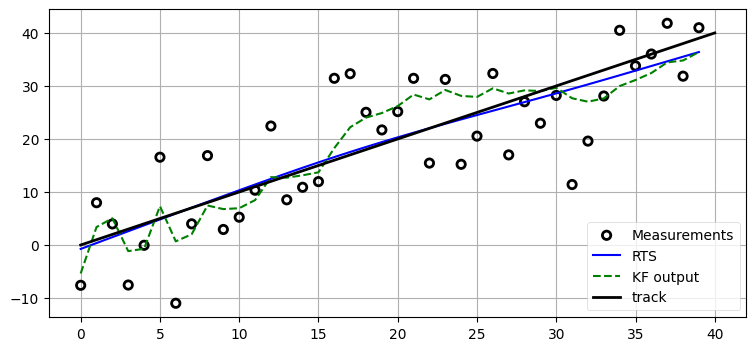

In [6]:
import numpy as np
from numpy import random
from numpy.random import randn
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
import kf_book.book_plots as bp

def plot_rts(noise, Q=0.001, show_velocity=False):
    random.seed(123)
    fk = KalmanFilter(dim_x=2, dim_z=1)

    fk.x = np.array([0., 1.])      # state (x and dx)

    fk.F = np.array([[1., 1.],
                     [0., 1.]])    # state transition matrix

    fk.H = np.array([[1., 0.]])    # Measurement function
    fk.P*= 10.                     # covariance matrix
    fk.R = noise                   # state uncertainty
    fk.Q = Q_discrete_white_noise(dim=2, dt=1., var=Q)  # process uncertainty

    # create noisy data
    zs = np.asarray([t + randn()*noise for t in range (40)])

    # filter data with Kalman filter, than run smoother on it
    mu, cov, _, _ = fk.batch_filter(zs)
    M, P, C, _ = fk.rts_smoother(mu, cov)

    # plot data
    if show_velocity:
        index = 1
        print('gu')
    else:
        index = 0
    if not show_velocity:
        bp.plot_measurements(zs, lw=1)
    plt.plot(M[:, index], c='b', label='RTS')
    plt.plot(mu[:, index], c='g', ls='--', label='KF output')
    if not show_velocity:
        N = len(zs)
        plt.plot([0, N], [0, N], 'k', lw=2, label='track') 
    plt.legend(loc=4)
    plt.show()
    
plot_rts(7.)

I've injected a lot of noise into the signal to allow you to visually distinguish the RTS output from the ideal output. In the graph above we can see that the Kalman filter, drawn as the green dotted line, is reasonably smooth compared to the input, but it still wanders from from the ideal line when several measurements in a row are biased towards one side of the line. In contrast, the RTS output is both extremely smooth and very close to the ideal output.

With a perhaps more reasonable amount of noise we can see that the RTS output nearly lies on the ideal output. The Kalman filter output, while much better, still varies by a far greater amount.

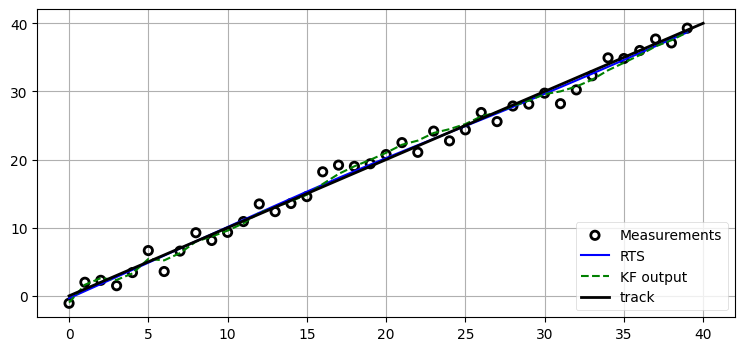

In [7]:
plot_rts(noise=1.)

However, we must understand that this smoothing is predicated on the system model. We have told the filter that what we are tracking follows a constant velocity model with very low process error. When the filter *looks ahead* it sees that the future behavior closely matches a constant velocity so it is able to reject most of the noise in the signal. Suppose instead our system has a lot of process noise. For example, if we are tracking a light aircraft in gusty winds its velocity will change often, and the filter will be less able to distinguish between noise and erratic movement due to the wind. We can see this in the next graph.  

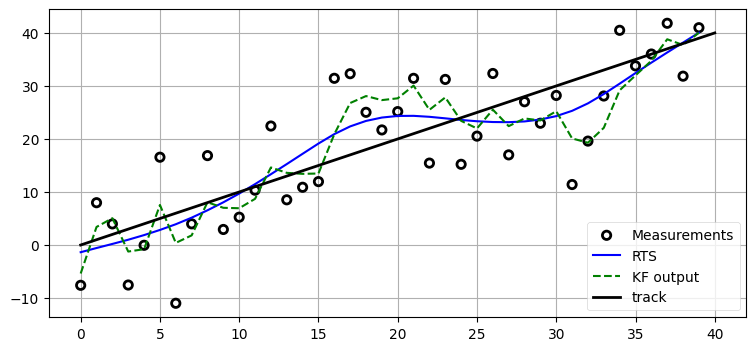

In [8]:
plot_rts(noise=7., Q=.1)

This underscores the fact that these filters are not *smoothing* the data in colloquial sense of the term. The filter is making an optimal estimate based on previous measurements, future measurements, and what you tell it about the behavior of the system and the noise in the system and measurements.

Let's wrap this up by looking at the velocity estimates of Kalman filter vs the RTS smoother.

gu


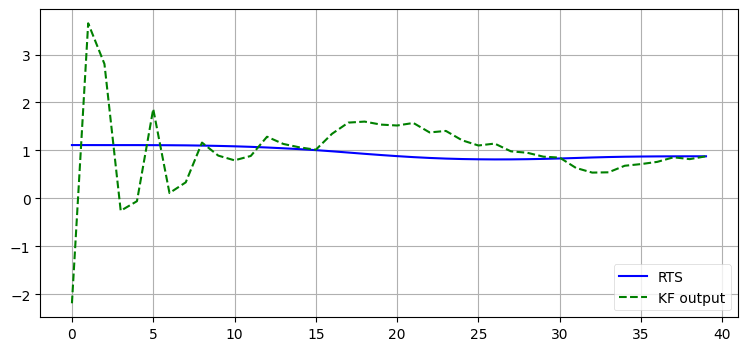

In [9]:
plot_rts(7.,show_velocity=True)

The improvement in the velocity, which is an hidden variable, is even more dramatic. 

## Fixed-Lag Smoothing

The RTS smoother presented above should always be your choice of algorithm if you can run in batch mode because it incorporates all available data into each estimate. Not all problems allow you to do that, but you may still be interested in receiving smoothed values for previous estimates. The number line below illustrates this concept.

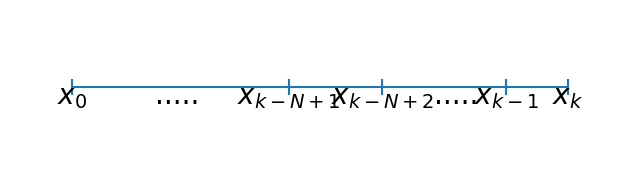

In [10]:
from kf_book.book_plots import figsize
from kf_book.smoothing_internal import *

with figsize(y=2):
    show_fixed_lag_numberline()

At step $k$ we can estimate $x_k$ using the normal Kalman filter equations. However, we can make a better estimate for $x_{k-1}$ by using the measurement received for $x_k$. Likewise, we can make a better estimate for $x_{k-2}$ by using the measurements recevied for $x_{k-1}$ and $x_{k}$. We can extend this computation back for an arbitrary $N$ steps.

Derivation for this math is beyond the scope of this book; Dan Simon's *Optimal State Estimation* [2] has  a very good exposition if you are interested. The essense of the idea is that instead of having a state vector $\mathbf{x}$ we make an augmented state containing

$$\mathbf{x} = \begin{bmatrix}\mathbf{x}_k \\ \mathbf{x}_{k-1} \\ \vdots\\ \mathbf{x}_{k-N+1}\end{bmatrix}$$

This yields a very large covariance matrix that contains the covariance between states at different steps. FilterPy's class `FixedLagSmoother` takes care of all of this computation for you, including creation of the augmented matrices. All you need to do is compose it as if you are using the `KalmanFilter` class and then call `smooth()`, which implements the predict and update steps of the algorithm. 

Each call of `smooth` computes the estimate for the current measurement, but it also goes back and adjusts the previous `N-1` points as well. The smoothed values are contained in the list `FixedLagSmoother.xSmooth`. If you use `FixedLagSmoother.x` you will get the most recent estimate, but it is not smoothed and is no different from a standard Kalman filter output.


在第 $k$ 步，我们可以使用常规卡尔曼滤波方程估计 $x_k$。然而，通过利用接收到的 $x_k$ 测量值，我们可以对 $x_{k-1}$ 进行更精确的估计。同样地，通过结合接收到的 $x_{k-1}$ 和 $x_k$ 的测量值，我们可以对 $x_{k-2}$ 进行更精确的估计。该计算可向后扩展任意$N$步。

此数学推导超出本书范围；若感兴趣，Dan Simon的《最优状态估计》[2]对此有精彩阐述。核心思想在于：我们不再使用状态向量$\mathbf{x}$，而是构建一个扩展状态向量：

$$\mathbf{x} = \begin{bmatrix}\mathbf{x}_k \\ \mathbf{x}_{k-1} \\ \vdots\\ \mathbf{x}_{k-N+1}\end{bmatrix}$$

这将产生包含不同步长状态间协方差的超大协方差矩阵。FilterPy的`FixedLagSmoother`类会自动完成所有计算，包括扩展矩阵的构建。您只需像使用`KalmanFilter`类那样组合该类，然后调用`smooth()`方法即可——该方法实现了算法的预测与更新步骤。

每次调用`smooth`不仅会计算当前观测值的估计，还会回溯调整前`N-1`个观测点。平滑后的值存储在列表`FixedLagSmoother.xSmooth`中。若使用`FixedLagSmoother.x`则获取最新估计值，但该值未经平滑处理，与标准卡尔曼滤波器输出无异。

standard deviation fixed-lag: 2.616
standard deviation kalman: 3.564


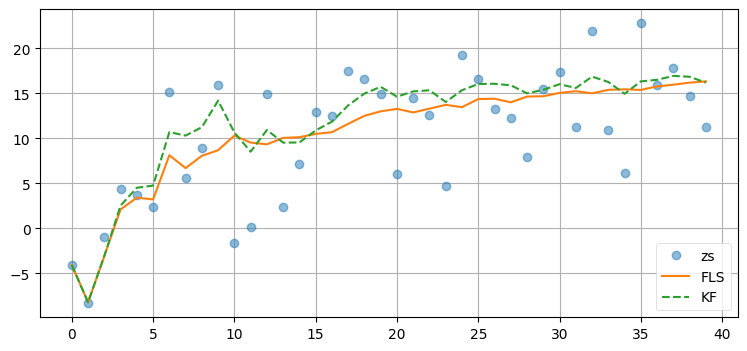

: 

In [ ]:
from filterpy.kalman import FixedLagSmoother, KalmanFilter
import numpy.random as random

fls = FixedLagSmoother(dim_x=2, dim_z=1, N=8)

fls.x = np.array([0., .5])
fls.F = np.array([[1.,1.],
                  [0.,1.]])

fls.H = np.array([[1.,0.]])
fls.P *= 200
fls.R *= 5.
fls.Q *= 0.001

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([0., .5])
kf.F = np.array([[1.,1.],
                 [0.,1.]])
kf.H = np.array([[1.,0.]])
kf.P *= 200
kf.R *= 5.
kf.Q = Q_discrete_white_noise(dim=2, dt=1., var=0.001)

nom =  np.array([t/2. for t in range (0, 40)])
zs = np.array([t + random.randn()*5.1 for t in nom])

for z in zs:
    fls.smooth(z)
    
kf_x, _, _, _ = kf.batch_filter(zs)
x_smooth = np.array(fls.xSmooth)[:, 0]


fls_res = abs(x_smooth - nom)
kf_res = abs(kf_x[:, 0] - nom)

plt.plot(zs,'o', alpha=0.5, label='zs')
plt.plot(x_smooth, label='FLS')
plt.plot(kf_x[:, 0], label='KF', ls='--')
plt.legend(loc=4)

print(f'standard deviation fixed-lag: {np.mean(fls_res):.3f}')
print(f'standard deviation kalman: {np.mean(kf_res):.3f}')

Here I have set `N=8` which means that we will incorporate 8 future measurements into our estimates. This provides us with a very smooth estimate once the filter converges, at the cost of roughly 8x the amount of computation of the standard Kalman filter. Feel free to experiment with larger and smaller values of `N`. I chose 8 somewhat at random, not due to any theoretical concerns.

## References

- [1] H. Rauch, F. Tung, and C. Striebel. "Maximum likelihood estimates of linear dynamic systems," *AIAA Journal*, **3**(8), pp. 1445-1450 (August 1965). http://arc.aiaa.org/doi/abs/10.2514/3.3166

- [2] Dan Simon. "Optimal State Estimation," John Wiley & Sons, 2006.